In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ColabNotebooks/ML/natural_gas_forecasting/

/content/drive/MyDrive/ColabNotebooks/ML/natural_gas_forecasting


### Develop LSTM Models For Univariate Time Series Forecasting

In [3]:

# univariate lstm example
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [27]:
data = pd.read_csv("processed_nasdaq.csv", index_col="Date", parse_dates=True)
data = data.drop(['vol'], axis=1)
seasons = {"Spring": 1,
           "Summer": 2,
           "Autumn": 3,
           "Winter": 4}
data["season"] = data.season.map(seasons)
data = data[::-1]
data

,close,open,high,last,season
Date,,,,,
2012-05-02,2.253,2.371,2.384,2.236,1
2012-05-03,2.340,2.260,2.379,2.253,1
2012-05-04,2.279,2.340,2.373,2.265,1
2012-05-07,2.336,2.277,2.358,2.273,1
2012-05-08,2.393,2.323,2.460,2.280,1
...,...,...,...,...,...
2022-04-25,6.669,6.414,6.966,6.345,1
2022-04-26,6.850,6.836,7.050,6.662,1
2022-04-27,7.267,6.858,7.344,6.800,1


In [28]:
data.describe()

,close,open,high,last,season
count,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000
mean,3.140832,3.140889,3.206009,3.079205,2.482164
std,0.897693,0.892895,0.929465,0.868152,1.113366
min,1.482000,1.441000,1.567000,1.432000,1.000000
25%,2.607000,2.618000,2.665000,2.565000,1.000000
50%,2.924000,2.924000,2.971000,2.881000,2.000000
75%,3.658000,3.658500,3.719000,3.599500,3.000000
max,7.820000,7.776000,8.065000,7.365000,4.000000


In [8]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [10]:
data.isnull().sum()

close     0
open      0
high      0
last      0
season    0
dtype: int64

In [29]:
scaler = StandardScaler()
scaler = scaler.fit(data)
scaled_data = scaler.transform(data)

In [37]:
scaled_data[:50, 0]

array([-0.98920895, -0.89227485, -0.96024014, -0.89673159, -0.83322304,
       -0.75300172, -0.72848965, -0.70397758, -0.79088401, -0.71400524,
       -0.58253141, -0.60927185, -0.44437246, -0.59255907, -0.48336894,
       -0.44994339, -0.55022004, -0.63824066, -0.63824066, -0.79311238,
       -0.80536842, -0.80091168, -0.90787344, -0.80871097, -0.77417123,
       -0.80202586, -0.96581106, -0.93795644, -1.02820542, -1.01260683,
       -1.06497353, -0.71957617, -0.75077335, -0.56359026, -0.66386691,
       -0.6950641 , -0.62264207, -0.57473211, -0.49785334, -0.41651783,
       -0.40871854, -0.46665616, -0.35300929, -0.35300929, -0.26944541,
       -0.26944541, -0.2181929 , -0.40649017, -0.28727237, -0.44994339])

In [33]:
'''
# define input sequence
timeseries_data = [110, 125, 133, 146, 158, 172, 187, 196, 210]
# choose a number of time steps
n_steps = 3
# split into samples
'''
pred_range = 10

timeseries_data = scaled_data[:-pred_range, 0]
n_steps = 7
X, y = prepare_data(timeseries_data, n_steps)

In [34]:
print(X),print(y)

[[-0.98920895 -0.89227485 -0.96024014 ... -0.83322304 -0.75300172
  -0.72848965]
 [-0.89227485 -0.96024014 -0.89673159 ... -0.75300172 -0.72848965
  -0.70397758]
 [-0.96024014 -0.89673159 -0.83322304 ... -0.72848965 -0.70397758
  -0.79088401]
 ...
 [ 2.8736706   2.86475712  3.22129633 ...  3.58563484  3.49538586
   3.9020634 ]
 [ 2.86475712  3.22129633  3.21795378 ...  3.49538586  3.9020634
   3.94328824]
 [ 3.22129633  3.21795378  3.58563484 ...  3.9020634   3.94328824
   4.2964849 ]]
[-0.70397758 -0.79088401 -0.71400524 ...  3.94328824  4.2964849
  4.63408297]


(None, None)

In [13]:
X.shape

(2534, 7)

In [14]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [15]:
X.shape

(2534, 7, 1)

### Building LSTM Model

In [16]:

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=0)


### Predicting For the next 10 data

In [17]:
initial = [*map(float, X[-1, 1:]), y[-1]]
initial

[6.029, 6.359, 6.278, 6.643, 6.68, 6.997, 7.3]

In [18]:
# demonstrate prediction for next 10 days
x_input = np.array(initial)
temp_input=list(x_input)
lst_output=[]
i=0
while(i<pred_range):
    
    if(len(temp_input)>n_steps):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

[7.3767095]
1 day input [6.359      6.278      6.643      6.68       6.997      7.3
 7.37670946]
1 day output [[7.487918]]
2 day input [6.278      6.643      6.68       6.997      7.3        7.37670946
 7.4879179 ]
2 day output [[7.5368056]]
3 day input [6.643      6.68       6.997      7.3        7.37670946 7.4879179
 7.53680563]
3 day output [[7.610735]]
4 day input [6.68       6.997      7.3        7.37670946 7.4879179  7.53680563
 7.61073494]
4 day output [[7.6885715]]
5 day input [6.997      7.3        7.37670946 7.4879179  7.53680563 7.61073494
 7.68857145]
5 day output [[7.768081]]
6 day input [7.3        7.37670946 7.4879179  7.53680563 7.61073494 7.68857145
 7.76808119]
6 day output [[7.842924]]
7 day input [7.3767095 7.487918  7.5368056 7.610735  7.6885715 7.768081  7.842924 ]
7 day output [[7.9150314]]
8 day input [7.487918  7.5368056 7.610735  7.6885715 7.768081  7.842924  7.9150314]
8 day output [[7.9826617]]
9 day input [7.5368056 7.610735  7.6885715 7.768081  7.842924  7

In [19]:
data.close[-10:]

Date
2022-04-18    7.820
2022-04-19    7.176
2022-04-20    6.937
2022-04-21    6.957
2022-04-22    6.534
2022-04-25    6.669
2022-04-26    6.850
2022-04-27    7.267
2022-04-28    6.888
2022-04-29    7.244
Name: close, dtype: float64

In [20]:
len(timeseries_data)

2541

In [21]:
lst_output

[7.3767095,
 7.487918,
 7.5368056,
 7.610735,
 7.6885715,
 7.768081,
 7.842924,
 7.9150314,
 7.9826617,
 8.048873]

In [22]:
lst=x_input
lst

array([[[7.5368056],
        [7.610735 ],
        [7.6885715],
        [7.768081 ],
        [7.842924 ],
        [7.9150314],
        [7.9826617]]], dtype=float32)

### Visualizaing The Output

In [23]:
import matplotlib.pyplot as plt

In [24]:
l = len(timeseries_data)
day_new=np.arange(1, pred_range+1)
day_pred=np.arange(1, pred_range+1)

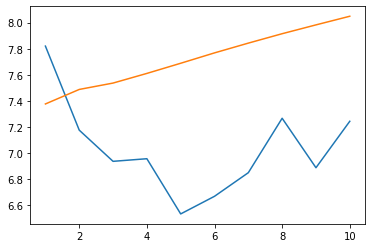

In [25]:
plt.plot(day_new, data.close[-10:])
plt.plot(day_pred, lst_output)